In [25]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# Загрузка и обработка данных

In [27]:
# Путь
path_train = "/kaggle/input/movie-reviews/aclImdb/train"
path_test = "/kaggle/input/movie-reviews/aclImdb/test"

# Загружаем данные
reviews_train = load_files(path_train, categories=['pos', 'neg'], encoding='utf-8')
text_train, y_train = reviews_train.data, reviews_train.target

reviews_test = load_files(path_test, categories=['pos', 'neg'], encoding='utf-8')
text_test, y_test = reviews_test.data, reviews_test.target


* **text_train** — тексты отзывов (список строк).
* **y_train** — целевые метки классов (массив чисел, где 0 — отрицательные отзывы, а 1 — положительные).


In [28]:
cv = CountVectorizer()
cv.fit(text_train)

print(len(cv.vocabulary_))

74849


Создаётся объект **CountVectorize**r, который используется для преобразования текстов в матрицу признаков на основе количества слов (bag-of-words).
По умолчанию:
* Все тексты преобразуются в нижний регистр.
* Убираются знаки препинания.
* Игнорируются слова, которые встречаются реже, чем 1 раз (или можно настроить минимальную частоту).


**cv.fit(text_train)**
Метод fit обучает CountVectorizer на тексте из text_train. Он:
* Выделяет все уникальные слова из текстов.
* Создаёт словарь (vocabulary), где каждому слову соответствует уникальный индекс.


**len(cv.vocabulary_)** Считается количество уникальных слов в словаре (размер словаря).

**cv.vocabulary_** — это словарь Python, где:
* Ключи — уникальные слова.
* Значения — индексы этих слов.


In [29]:
X_train = cv.transform(text_train)
X_test = cv.transform(text_test)

**Закодируем предложения индексами входящих слов:**
В CountVectorizer каждое слово в тексте будет преобразовано в индекс из словаря, созданного на основе обучающих данных. Преобразование происходит так:
* Для каждого слова из текста, если оно есть в словаре (созданном на основе обучающей выборки), будет подсчитано количество его вхождений.
* Индекс слова в словаре будет соответствовать позиции этого слова в разреженной матрице.


**Используем разреженный форма:т**
Поскольку большинство текстов будут содержать только несколько слов из общего словаря, матрица будет разреженной (то есть в основном состоящей из нулей). Это экономит память и ускоряет вычисления.
С использованием разреженной матрицы сохраняются только ненулевые элементы и их индексы

**Преобразуем так же тестовую выборку:**
Тестовая выборка преобразуется с использованием того же словаря, который был создан на обучающих данных. Это важно, чтобы избежать утечки данных (когда тестовые данные могли бы повлиять на построение модели).

In [30]:
X_train.shape

(25000, 74849)

In [31]:
#  Пример трансформации

# Пример текстов
#text_train = ["This is a great movie", "This movie is amazing", "Great movie"]

#Словарь (индексы слов):
# {'this': 5, 'is': 3, 'a': 0, 'great': 2, 'movie': 4, 'amazing': 1 }

# Разреженная матрица: 
# [[1 0 1 1 1 1]  # "This is a great movie"
#  [1 1 0 1 1 1]  # "This movie is amazing" 
#  [0 0 1 0 1 1]] # "Great movie"

# Объяснение: Для первой строки: слово "this" (индекс 5) встречается 1 раз, слово "is" (индекс 3) — 1 раз, и так далее.

# Обучение модели с использованием логистической регрессии

In [32]:
model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Оценка точности
model.score(X_test, y_test)

0.86336

# Коэффициенты модели логистической регрессии для анализа важности каждого признака (слова) в процессе классификации

In [33]:
def visualize_coefficients(classifier, feature_names, n_top_features=25):
    # get coefficients with large absolute values 
    coef = classifier.coef_.ravel()
    positive_coefficients = np.argsort(coef)[-n_top_features:]
    negative_coefficients = np.argsort(coef)[:n_top_features]
    interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
    # plot them
    plt.figure(figsize=(15, 5))
    colors = ["red" if c < 0 else "green" for c in coef[interesting_coefficients]]
    plt.bar(np.arange(2 * n_top_features), coef[interesting_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * n_top_features), feature_names[interesting_coefficients], rotation=60, ha="right");

def plot_grid_scores(grid, param_name):
    plt.plot(grid.param_grid[param_name], grid.cv_results_['mean_train_score'],
    color='green', label='train')
    plt.plot(grid.param_grid[param_name], grid.cv_results_['mean_test_score'],
    color='red', label='test')
    plt.legend();

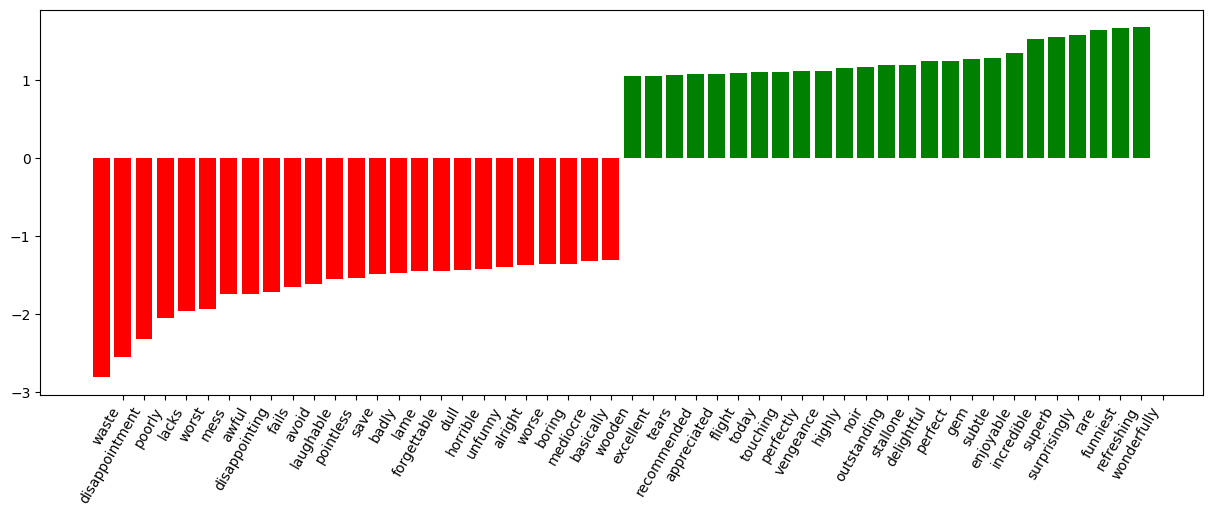

In [34]:
visualize_coefficients(model, cv.get_feature_names_out()) 
# get_feature_names_out() используется для получения списка всех уникальных признаков (слов), которые были извлечены в процессе преобразования текстовых данных с помощью CountVectorizer

**Пояснение к коду:**

**coef = classifier.coef_.ravel():**
* Извлекает коэффициенты классификатора. В случае с логистической регрессией, эти коэффициенты показывают важность каждого признака (слова) в предсказаниях.
* .ravel() используется для преобразования многомерного массива в одномерный, если классификатор использует несколько классов.

**positive_coefficients = np.argsort(coef)[-n_top_features:]:**
* Находит индексы признаков с наибольшими положительными коэффициентами.np.argsort(coef) возвращает индексы, отсортированные по значениям коэффициентов,
* [-n_top_features:] выбирает индексы с наибольшими значениями.

**negative_coefficients = np.argsort(coef)[:n_top_features]:**
* Находит индексы признаков с наименьшими (отрицательными) коэффициентами.
  
**interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients]):**
* Объединяет индексы с наибольшими отрицательными и положительными коэффициентами в один массив, чтобы затем отобразить наиболее важные признаки (слова).

**plt.bar(np.arange(2 * n_top_features), coef[interesting_coefficients], color=colors):**
* Строит гистограмму для коэффициентов этих признаков, где цвет столбцов зависит от знака коэффициента:

* * Красный (отрицательные коэффициенты) — слова, которые уменьшают вероятность положительного класса.
* * Зеленый (положительные коэффициенты) — слова, которые увеличивают вероятность положительного класса.


**plt.xticks(np.arange(1, 1 + 2 * n_top_features), feature_names[interesting_coefficients], rotation=60, ha="right"):**
* Устанавливает подписи для оси X — это слова, соответствующие выбранным признакам.
* Поворот подписей на 60° и выравнивание их по правому краю.


# Матрица ошибок

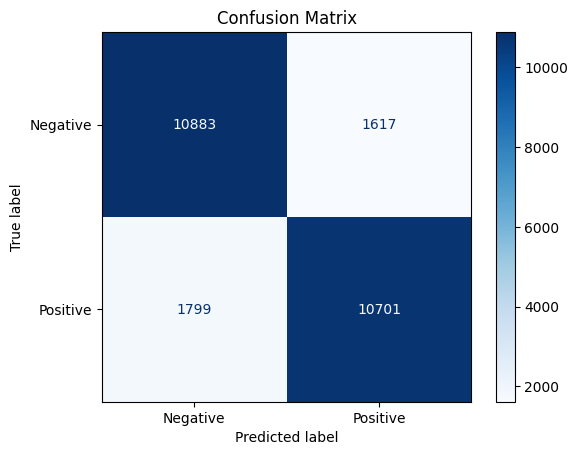

In [35]:

def plot_confusion_matrix(y_test, y_pred, class_names):
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap="Blues")
    plt.title("Confusion Matrix")
    plt.show()

plot_confusion_matrix(y_test, y_pred, class_names=["Negative", "Positive"])



* Верхний левый: 10,883 — правильно предсказанные "Negative" (True Negative).
* Верхний правый: 1,617 — "Negative" предсказаны как "Positive" (False Positive).
* Нижний левый: 1,799 — "Positive" предсказаны как "Negative" (False Negative).
* Нижний правый: 10,701 — правильно предсказанные "Positive" (True Positive).
